In [183]:
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
from alphatoe import plot, game, interpretability
from transformer_lens import HookedTransformer, HookedTransformerConfig
import json
import einops
import circuitsvis as cv
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from torch.nn.functional import cross_entropy, softmax

import matplotlib.pyplot as plt
from importlib import reload
from copy import copy
import pandas as pd
import random
from typing import List, Tuple

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
model = interpretability.load_model(
    "../scripts/models/prob all 8 layer control-20230718-185339"
)


In [185]:
def neuron_activations(seq):
    def hook(module, input, output):
        result = output.clone()
        module.captured_activations = result
        
    try:
        handle = model.blocks[0].mlp.hook_post.register_forward_hook(hook)
        _ = model(seq)
        activations = model.blocks[0].mlp.hook_post.captured_activations
        handle.remove()
    except Exception as e:
        handle.remove()
        raise e

    return activations

def get_content_embedding(seq: List) -> torch.Tensor:
    sequence = torch.tensor([seq])
    return model.embed(sequence)

def get_head_attention(seq: torch.Tensor) -> torch.Tensor:
    def hook(module, input, output):
        module.attention = output.clone()
    try:
        handle = model.blocks[0].hook_attn_out.register_forward_hook(hook)
        _ = model(seq)
        attention = model.blocks[0].hook_attn_out.attention
    except Exception as e:
        handle.remove()
        raise e
    
    return attention


In [186]:
winning_moves = [6,4,5]
content_embedding = get_content_embedding(winning_moves)
win_con_embedding = torch.sum(content_embedding[0], dim=0).view(1,1,128)
win_con_embedding.shape
con_emb = win_con_embedding[0,0]

In [187]:
fake_win = torch.tensor([10, 6, 10, 4, 10, 5])
attention = get_head_attention(fake_win)
sliced = attention[0,-1]

In [188]:
stack = torch.stack([con_emb, sliced])
print(stack.shape)
dot = stack @ stack.T
norms = torch.norm(stack, dim=1)
cosine_similarity_matrix = dot / (norms.view(-1, 1) * norms)

print(cosine_similarity_matrix)

torch.Size([2, 128])
tensor([[1.0000, 0.4065],
        [0.4065, 1.0000]], device='mps:0', grad_fn=<DivBackward0>)


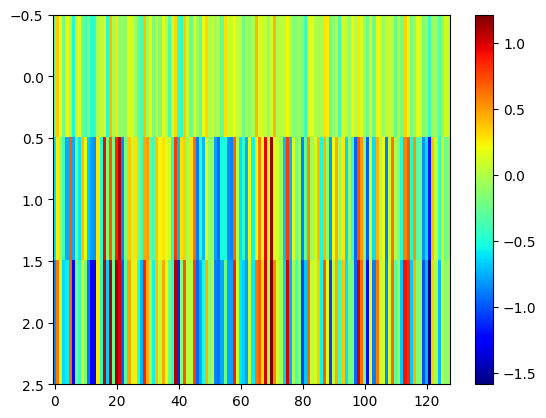

In [189]:
plus_resid = con_emb + sliced
resid_stack = torch.stack([con_emb, sliced, plus_resid])
plt.imshow(resid_stack.detach().cpu().numpy(), cmap='jet', aspect='auto')
plt.colorbar();

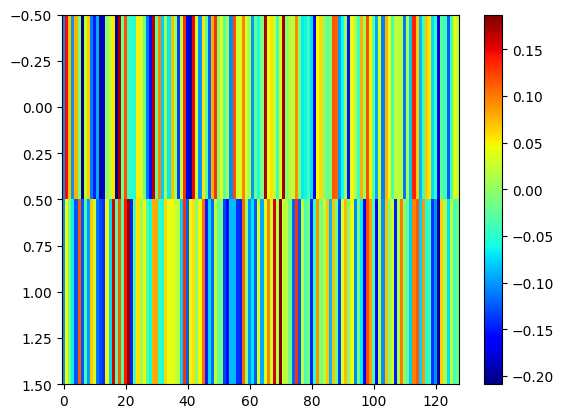

In [190]:
normalized_stack = stack / torch.norm(stack, dim=1, keepdim=True)
plt.imshow(normalized_stack.detach().cpu().numpy(), cmap='jet', aspect='auto')
plt.colorbar();

In [191]:
vector1 = stack[0, :]
vector2 = stack[1, :]


products = vector1 * vector2
absolute_products = np.abs(products.detach().cpu())
sorted_indices = np.argsort(-absolute_products)

print("Sorted indices by contribution:", sorted_indices)
print("Sorted contributions:", absolute_products[sorted_indices])

Sorted indices by contribution: tensor([121,   6,  12,  13,  40,  18,  39,  20, 101,  98, 113,  89,  29,  75,
        103,  55,  11,  58,  80,   0, 119,   4,  28,  41,  48,  47,  54,  42,
        124,  16,  87,  21,  81, 114,   9,  61, 115,  70,  22, 112,   8,   3,
          1,  17,  45,  65, 104,  57,  96, 120,  44,  32,  31,  10,  71,  99,
         66,  82,  46,  52,  56,  27,  68, 117, 116,  35,  24, 107,  49,  74,
         34,  62,  78, 118,  37,  88,  90,  15,  93,  38, 109,  63, 126,  23,
          5, 122,  30,  85,  67,  77,  92,  64,  94, 106,  60, 100,  26,  86,
         76, 125,   2,  83,   7, 102,  53,  69,  95,  33,  19,  51, 127,  79,
        123,  97, 110, 108, 111,  73,  14, 105,  43,  91,  36,  84,  72,  25,
         50,  59])
Sorted contributions: tensor([4.8036e-01, 3.7838e-01, 3.6834e-01, 3.6778e-01, 2.9597e-01, 2.8043e-01,
        2.4592e-01, 2.3906e-01, 2.2040e-01, 2.0552e-01, 1.8975e-01, 1.8792e-01,
        1.8421e-01, 1.7324e-01, 1.6080e-01, 1.5023e-01, 1.4899e-0

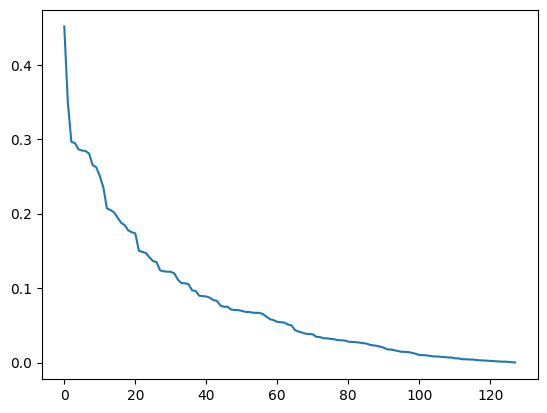

In [192]:
plt.plot(sorted_contributions.detach().cpu().numpy())

In [200]:
random_indices = torch.randperm(128)
mask = torch.zeros_like(vector1)
mask[sorted_indices[:52]] = 1
masked_con = mask * vector1
masked_con = masked_con.view(1,1,128)
anti_mask = torch.zeros_like(vector1)
anti_mask[sorted_indices[52:]] = 1
anti_mask_con = anti_mask * vector1
anti_mask_con = anti_mask_con.view(1,1,128)
con_emb = vector1.view(1,1,128)
rand_mask = torch.zeros_like(vector1)
rand_mask[random_indices[:52]] = 1
rand_mask_con = rand_mask * vector1
rand_mask_con = rand_mask_con.view(1,1,128)

In [201]:
logits_mask_con = model.blocks[0].mlp(masked_con) @ model.W_U
logits_anti_con = model.blocks[0].mlp(anti_mask_con) @ model.W_U
logits_rand_con = model.blocks[0].mlp(rand_mask_con) @ model.W_U
logits_con = model.blocks[0].mlp(con_emb) @ model.W_U


In [202]:
print("masked: " , logits_mask_con)
print("anti mask: " , logits_anti_con)
print("random mask: ", logits_rand_con)
print("content emb logits: " , logits_con)
logits_stack = torch.stack([logits_mask_con[0,0], logits_anti_con[0,0], logits_rand_con[0,0], logits_con[0,0]])

masked:  tensor([[[  4.6769,   3.2046,   3.3286,   3.9267,  -2.1918,  -1.7006,  -5.9997,
            4.3436,   5.4177, -13.2260]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)
anti mask:  tensor([[[-0.3052,  1.2514, -0.1121,  0.1672, -1.2610,  0.4262, -0.7898,
          -0.1000, -0.2062,  0.1552]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)
random mask:  tensor([[[ 2.2283,  1.6735,  0.2717,  0.5780, -0.6134, -2.3124, -5.8169,
           0.3215,  1.2520,  0.7408]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)
content emb logits:  tensor([[[  4.1052,   4.4193,   3.1072,   3.7611,  -3.5803,  -0.8958,  -6.3266,
            3.8502,   5.3801, -12.6790]]], device='mps:0',
       grad_fn=<UnsafeViewBackward0>)


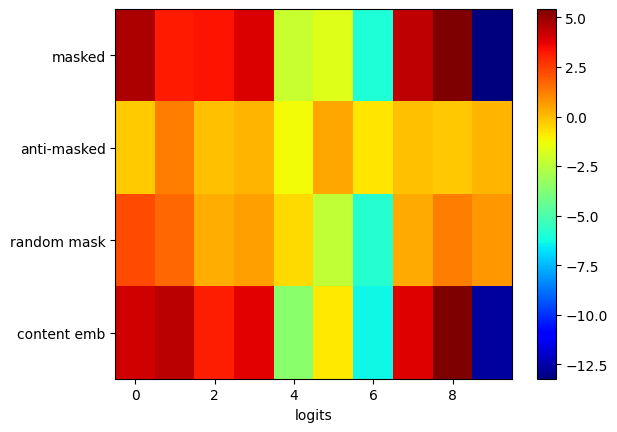

In [203]:
plt.imshow(logits_stack.detach().cpu().numpy(), cmap='jet', aspect='auto')
plt.colorbar()
#y labels
plt.yticks([0,1,2,3], ["masked", "anti-masked", "random mask", "content emb"]);
#xlabel
plt.xlabel("logits")
plt.gcf().set_facecolor("white")

In [197]:
mask_losses = []
for i in range(len(vector1)):
    mask = torch.zeros_like(vector1)
    mask[sorted_indices[:i]] = 1
    masked_con = mask * vector1
    masked_con = masked_con.view(1,1,128)
    logits_mask_con = model.blocks[0].mlp(masked_con) @ model.W_U
    mask_losses.append(cross_entropy(logits_mask_con.view(1,10), softmax(logits_con.view(1,10))))

mask_losses = torch.stack(mask_losses)

/var/folders/jh/gspcnp354xbck5dcmyhvt_2r0000gn/T/ipykernel_11431/3129035310.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mask_losses.append(cross_entropy(logits_mask_con.view(1,10), softmax(logits_con.view(1,10))))


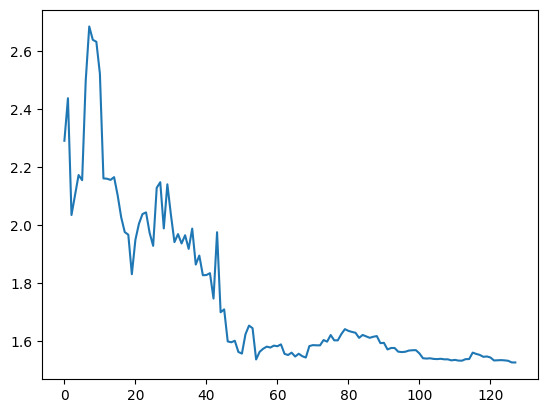

In [198]:
plt.plot(mask_losses.detach().cpu().numpy())